In [1]:
import os,sys,time,copy
import random
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy.integrate import fixed_quad,quad 
#from  numba import jit,objmode,njit
from tqdm import tqdm



#--matplotlib
import matplotlib
from matplotlib.lines import Line2D
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]
matplotlib.rc('text',usetex=True)
import pylab as py
from matplotlib import colors
import matplotlib.gridspec as gridspec

#--torch
import torch
import torch.nn as nn
import torch.optim as optim

print(torch.cuda.is_available())
torch.cuda.empty_cache()
manualSeed = 999 # Set random seed for reproducibility
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
#torch.use_deterministic_algorithms(True) # Needed for reproducible results
#! Number of GPUs available. Use 0 for CPU mode.
ngpu = 1 
#! Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

<ipython-input-1-fa3101f49374>:15: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


True
Random Seed:  999


In [2]:
class TDATA:
    
    def __init__(self,nx,ny,w=0.1):
        
        x=torch.linspace(-1,1,nx)
        y=torch.linspace(-1,1,ny)
        x_,y_=torch.meshgrid(x,y)
        
        img=torch.exp(-2.1*(x_**2+y_**2))
        fimg=img.flatten()
        self.x=x;self.x_=x_ 
        self.y=y;self.y_=y_ 
        self.img=img;self.fimg=fimg
        self.w=w
        self.nx=nx;self.ny=ny
        self.size=nx*ny
        
    def gen_samples(self,batch):
        return self.fimg*(1+self.w*np.random.randn(batch,self.fimg.size()[0]))
    
    def plot_img(self,ax,fimg,vmin=-1,vmax=1,cmap='gist_rainbow'):
        img=fimg.reshape(self.img.shape)
        c=ax.pcolor(self.x_.numpy(), self.y_.numpy(), img.numpy()
                    ,vmin=vmin, vmax=vmax,cmap=cmap)
        fig.colorbar(c, ax=ax)

In [3]:
nx=40;ny=40
tdata=TDATA(nx,ny,0.1)

/opt/conda/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


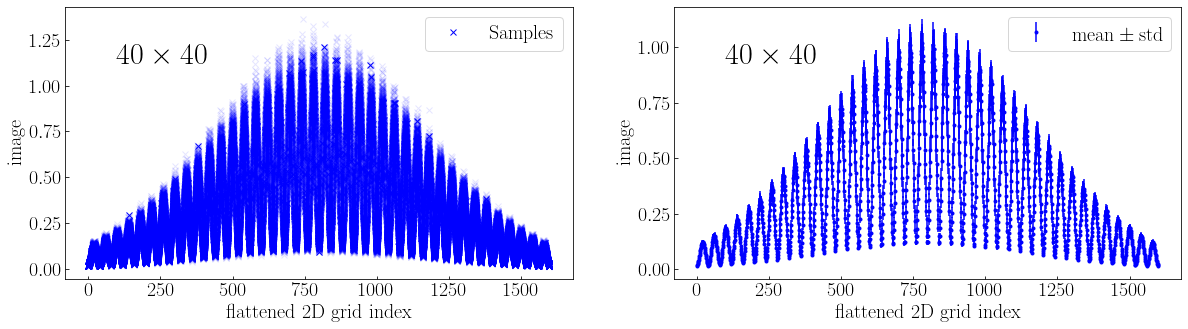

In [4]:
nrows,ncols=1,2;AX=[]
fig = py.figure(figsize=(ncols*10,nrows*5))

ax=py.subplot(nrows,ncols,1);AX.append(ax)
samples=tdata.gen_samples(100)
I=np.arange(tdata.nx*tdata.ny)
for sample in samples:
    ax.plot(I,sample,'bx',alpha=0.1)
ax.plot(I,sample,'bx',alpha=1,label=r'$\rm Samples$')

ax=py.subplot(nrows,ncols,2);AX.append(ax)
mean=torch.mean(samples,axis=0)
std=torch.std(samples,axis=0)
ax.errorbar(I+0.2,mean,std,fmt='b.',label=r'$\rm mean \pm std$')

for ax in AX:
    ax.tick_params(axis='both', which='major',labelsize=20,direction='in')
    ax.set_ylabel(r'$\rm image$',size=20)
    ax.set_xlabel(r'$\rm flattened~2D~grid~index$',size=20)
    ax.legend(fontsize=20)
    ax.text(0.1,0.8,r'$%d\times%d$'%(nx,ny),size=30,transform=ax.transAxes)

In [14]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        #nn.init.normal_(m.weight.data, 0.0, 0.7)
        nn.init.normal_(m.weight.data, 0.0, 0.1)

class Generator(nn.Module):
    def __init__(self, tdata):
        super(Generator, self).__init__()
        
        self.main = nn.Sequential(
            nn.Linear(tdata.size,tdata.size),
            )
    def forward(self, input):
        return self.main(input)
    
class Discriminator(nn.Module):
    def __init__(self,tdata):
        super(Discriminator, self).__init__()
        x=1
        self.main = nn.Sequential(
            nn.Linear(tdata.size, x*tdata.size),
            nn.ReLU(),
            nn.Linear(x*tdata.size, 1),
            nn.Sigmoid())        
    def forward(self, input):
        return self.main(input)


In [87]:
netG = Generator(tdata).to(device)
netG.apply(weights_init);
netG_copy = copy.deepcopy(netG) 
netD = Discriminator(tdata).to(device)
netD.apply(weights_init);
Gpar = sum(p.numel() for p in netG.parameters() if p.requires_grad)
Dpar = sum(p.numel() for p in netD.parameters() if p.requires_grad)
print('Gpar=%0.0e Dpar=%0.0e tot=%0.0e'%(Gpar,Dpar,Gpar+Dpar))

Gpar=3e+06 Dpar=3e+06 tot=5e+06


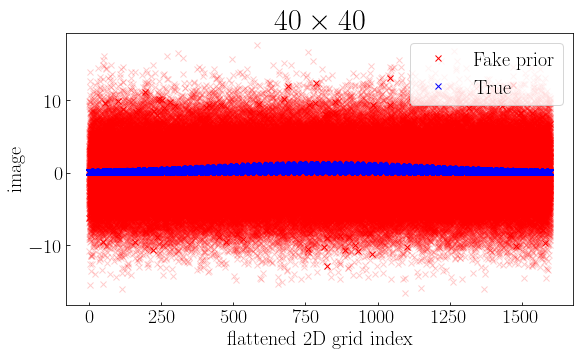

In [88]:
nrows,ncols=1,2;AX=[]
fig = py.figure(figsize=(ncols*10,nrows*5))

ax=py.subplot(nrows,ncols,1);AX.append(ax)

noise = torch.randn(10000,tdata.nx*tdata.ny, device=device)
samples=netG(noise).cpu().detach()
I=np.arange(tdata.nx*tdata.ny)
for sample in samples[:100]:
    ax.plot(I+0.4,sample,'rx',alpha=0.2)
ax.plot(I,sample,'rx',alpha=1,label=r'$\rm Fake~prior$')

samples=tdata.gen_samples(100)
I=np.arange(tdata.nx*tdata.ny)
for sample in samples:
    ax.plot(I,sample,'bx',alpha=0.2)
ax.plot(I,sample,'bx',alpha=1,label=r'$\rm True$')


ax.tick_params(axis='both', which='major',labelsize=20,direction='in')
ax.set_ylabel(r'$\rm image$',size=20)
ax.set_xlabel(r'$\rm flattened~2D~grid~index$',size=20)
ax.legend(loc=1,fontsize=20)
ax.set_title(r'$%d\times%d$'%(nx,ny),size=30);

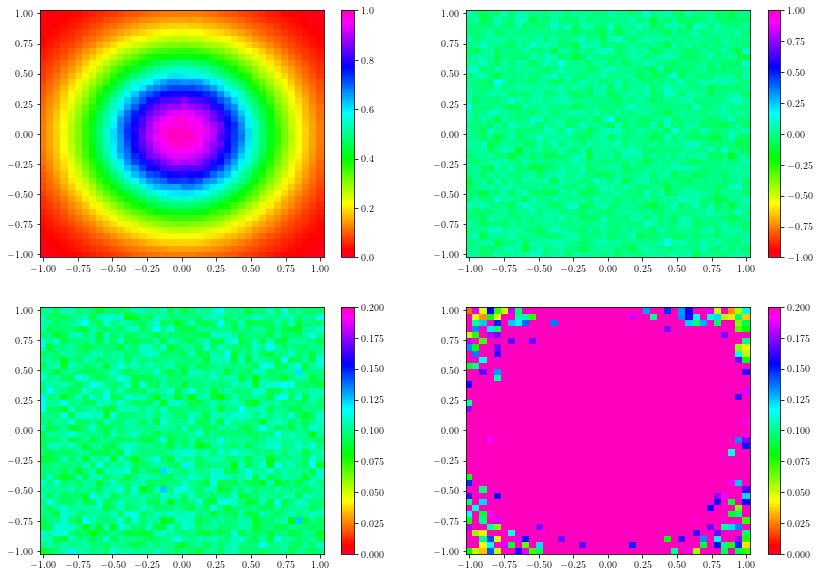

In [89]:
nrows,ncols=2,2;AX=[]
fig = py.figure(figsize=(ncols*7,nrows*5))

ax=py.subplot(nrows,ncols,1);AX.append(ax)
samples=tdata.gen_samples(100)
mean=torch.mean(samples,axis=0)
tdata.plot_img(ax,mean,vmin=0,vmax=1)

ax=py.subplot(nrows,ncols,3);AX.append(ax)
samples=tdata.gen_samples(100)
std=torch.std(samples/mean,axis=0)
tdata.plot_img(ax,std,vmin=0,vmax=0.2)

ax=py.subplot(nrows,ncols,2);AX.append(ax)
noise = torch.randn(10000,tdata.size, device=device)
samples=netG(noise).cpu().detach()
mean=torch.mean(samples,axis=0)
tdata.plot_img(ax,mean)

ax=py.subplot(nrows,ncols,4);AX.append(ax)
samples=tdata.gen_samples(100)
std=torch.std(samples/mean,axis=0)
tdata.plot_img(ax,std,vmin=0,vmax=0.2)


In [90]:
#! Initialize the ``BCELoss`` function
criterion = nn.BCELoss()
#criterion = nn.MSELoss()


#! Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

#! Learning rate for optimizers
lr = 0.0002
lr = 0.0002
#! Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

#! Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

G_losses = []
D_losses = []

In [91]:
#clip_value = 0.00005
clip_value = 0.01

batch=100
for epoch in tqdm(range(20000)):

    samples=tdata.gen_samples(batch)
    samples=torch.tensor(samples,dtype=torch.float32).to(device)
    
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    b_size = samples.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
    # Forward pass real batch through D
    output = netD(samples).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()


    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size,tdata.size, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    for p in netD.parameters():
        p.data.clamp_(-clip_value, clip_value)
    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()
    
    
    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())
    

  0%|          | 0/20000 [00:00<?, ?it/s]<ipython-input-91-050334419eff>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  samples=torch.tensor(samples,dtype=torch.float32).to(device)
100%|██████████| 20000/20000 [02:42<00:00, 123.02it/s]


(0.0, 1.0)

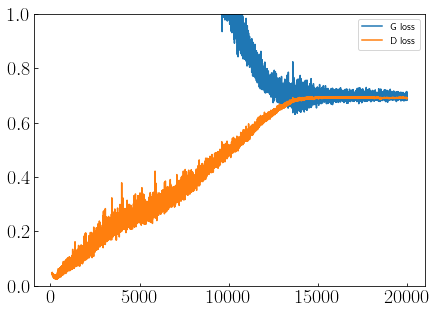

In [92]:
nrows,ncols=1,1
fig = py.figure(figsize=(ncols*7,nrows*5))
ax=py.subplot(nrows,ncols,1);AX.append(ax)
I=np.arange(len(G_losses))
ax.plot(I[100:],np.array(G_losses[100:]),label='G loss');
ax.plot(I[100:],np.array(D_losses[100:])/2,label='D loss');
ax.legend()
ax.tick_params(axis='both', which='major',labelsize=20,direction='in')
ax.set_ylim(0,1)

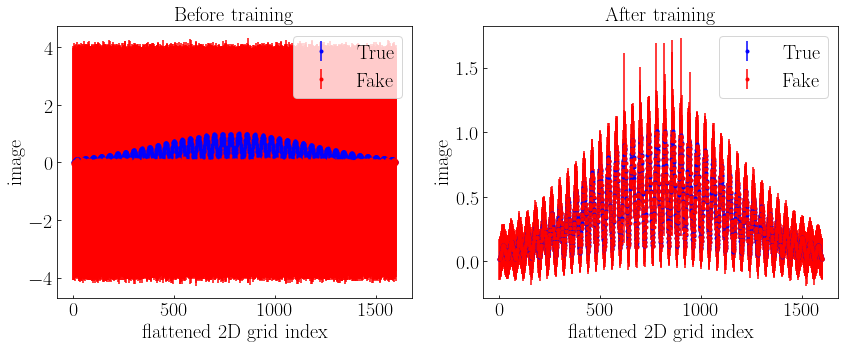

In [93]:
nrows,ncols=1,2;AX=[]
fig = py.figure(figsize=(ncols*7,nrows*5))

ax=py.subplot(nrows,ncols,1);AX.append(ax)
ax.set_title(r'$\rm Before~training$',size=20)
samples=tdata.gen_samples(100)
I=np.arange(tdata.size)
mean=torch.mean(samples,axis=0)
std=torch.std(samples,axis=0)
ax.errorbar(I+0.2,mean,std,fmt='b.',label=r'$\rm True$')

noise = torch.randn(10000,tdata.size, device=device)
samples=netG_copy(noise).cpu().detach()
I=np.arange(tdata.size)
mean=torch.mean(samples,axis=0)
std=torch.std(samples,axis=0)
ax.errorbar(I+0.6,mean,std,fmt='r.',label=r'$\rm Fake$')


ax=py.subplot(nrows,ncols,2);AX.append(ax)
ax.set_title(r'$\rm After~training$',size=20)
samples=tdata.gen_samples(100)
I=np.arange(tdata.size)
mean=torch.mean(samples,axis=0)
std=torch.std(samples,axis=0)
ax.errorbar(I+0.2,mean,std,fmt='b.',label=r'$\rm True$')

noise = torch.randn(10000,tdata.size, device=device)
samples=netG(noise).cpu().detach()
I=np.arange(tdata.size)
mean=torch.mean(samples,axis=0)
std=torch.std(samples,axis=0)
ax.errorbar(I+0.6,mean,std,fmt='r.',label=r'$\rm Fake$')

for ax in AX:
    ax.tick_params(axis='both', which='major',labelsize=20,direction='in')
    ax.set_ylabel(r'$\rm image$',size=20)
    ax.set_xlabel(r'$\rm flattened~2D~grid~index$',size=20)
    ax.legend(fontsize=20)

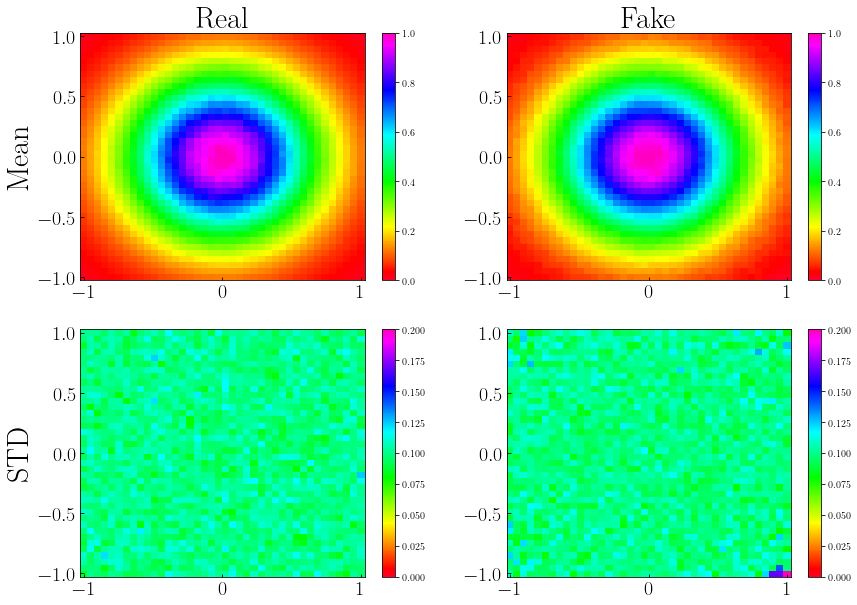

In [94]:
nrows,ncols=2,2;AX=[]
fig = py.figure(figsize=(ncols*7,nrows*5))

ax=py.subplot(nrows,ncols,1);AX.append(ax)
samples=tdata.gen_samples(100)
mean=torch.mean(samples,axis=0)
tdata.plot_img(ax,mean,vmin=0,vmax=1)
ax.set_title(r'$\rm Real$',size=30)
ax.set_ylabel(r'$\rm Mean$',size=30)

ax=py.subplot(nrows,ncols,3);AX.append(ax)
samples=tdata.gen_samples(100)
std=torch.std(samples/mean,axis=0)
tdata.plot_img(ax,std,vmin=0,vmax=0.2)
ax.set_ylabel(r'$\rm STD$',size=30)

ax=py.subplot(nrows,ncols,2);AX.append(ax)
noise = torch.randn(10000,tdata.size, device=device)
samples=netG(noise).cpu().detach()
mean=torch.mean(samples,axis=0)
tdata.plot_img(ax,mean,vmin=0,vmax=1)
ax.set_title(r'$\rm Fake$',size=30)

ax=py.subplot(nrows,ncols,4);AX.append(ax)
samples=tdata.gen_samples(100)
std=torch.std(samples/mean,axis=0)
tdata.plot_img(ax,std,vmin=0,vmax=0.2)

for ax in AX:
    ax.tick_params(axis='both', which='major',labelsize=20,direction='in')